# 3. Disciplines of Journals using OJS <a name=languages></a>

### Notebook objectives:
1. Translate concatenated titles and abstracts from 9 other languages into English using [UKP's EasyNMT neural machine translation package](#nmt) with <a href='https://github.com/Helsinki-NLP/Opus-MT'>Helsinki NLP's Opus MT</a> and <a href='https://github.com/facebookresearch/fairseq'>Facebook Research's fairseq 'mbart50_m2en' model</a>. This is necessary because the classifier was trained on English text.<br><br>
2. Classify the journals known to be actively using OJS by applying [Weber et al.'s (2020) neural field of study classifier](#fosc) to titles and abstracts
<br><br>
3. Create bar graphs representing the journals using OJS by their disciplinary distribution:
    1. [By discipline: 20 ANZSRC field of study labels](#disc)
    2. [By division: STEM, Social Sciences, and Humanities](#div)

Import packages:

In [1]:
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import ijson
import json
import time
import re
import os

### 1. Translating jounal titles and abstracts with <a href='https://github.com/UKPLab/EasyNMT'>UKP's EasyNMT neural machine translator</a><a id='nmt'></a>

Import EasyNMT:

In [2]:
import tensorflow
from easynmt import EasyNMT

/Users/jball/opt/anaconda3/envs/ojs/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/jball/opt/anaconda3/envs/ojs/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for 

First, create a function that:
<br>
1. Reads each of the Indonesian, Spanish, and Portuguese .json files mapping journal ISSNs to concatenated article titles and abstracts, or payloads;
<br><br>
2. Translates the payloads for each journal from the specified source language ('id', 'es', 'pt') to the target language, English ('en');
<br><br>
3. Saves a dictionary mapping journal ISSN to translated payload as a .json file:

In [3]:
def translate(infile, outfile, issns_en, model, source_lang):
    issn2translation = {}
    
    with open(infile, 'r') as infile_:
        d = json.load(infile_)
        d_ = {}
        for k, v in d.items():
            if k not in issns_en:
                d_[k] = v
        del d   
        
    print('{} examples loaded.'.format(len(d_)))
    
    print('Translating payloads...')
    for k, v in tqdm(list(d_.items())):
        issn2translation[k] = model.translate(v, source_lang=source_lang, target_lang='en')
    
    with open(outfile, 'w') as outfile_:
        json.dump(issn2translation, outfile_)
    print('Translated payloads saved.')

In [4]:
infile_en = os.path.join('data', 'issn2en.json')
with open(infile_en, 'r') as infile:
    en = json.load(infile)
    issns_en = list(en.keys())
opus = EasyNMT('opus-mt')

Bahasa Indonesia:

In [5]:
infile_id = os.path.join('data', 'issn2id.json')
outfile_id = os.path.join('data', 'issn2id_trans.json')
%time translate(infile=infile_id, outfile=outfile_id, issns_en=issns_en, model=opus, source_lang='id')

998 examples loaded.
Translating payloads...


100%|███████████████████████████████████████| 998/998 [6:31:37<00:00, 23.54s/it]

Translated payloads saved.
CPU times: user 6h 12s, sys: 2h 24min 13s, total: 8h 24min 26s
Wall time: 6h 31min 40s


Spanish:

In [6]:
infile_es = os.path.join('data', 'issn2es.json')
outfile_es = os.path.join('data', 'issn2es_trans.json')
%time translate(infile=infile_es, outfile=outfile_es, issns_en=issns_en, model=opus, source_lang='es')

588 examples loaded.
Translating payloads...


100%|███████████████████████████████████████| 588/588 [2:12:36<00:00, 13.53s/it]

Translated payloads saved.
CPU times: user 2h 4min 32s, sys: 38min 50s, total: 2h 43min 23s
Wall time: 2h 12min 37s


Portuguese:

In [7]:
mbart = EasyNMT('mbart50_m2en') #Facebook (Meta) mbart50_m2en for pt & uk -> en

In [8]:
infile_pt = os.path.join('data', 'issn2pt.json')
outfile_pt = os.path.join('data', 'issn2pt_trans.json')

%time translate(infile=infile_pt, outfile=outfile_pt, issns_en=issns_en, model=mbart, source_lang='pt')

557 examples loaded.
Translating payloads...


100%|██████████████████████████████████████| 557/557 [13:08:13<00:00, 84.91s/it]

Translated payloads saved.
CPU times: user 12h 7min 45s, sys: 3h 22min 29s, total: 15h 30min 14s
Wall time: 13h 8min 15s


Afrikaans:

In [9]:
infile_af = os.path.join('data', 'issn2af.json')
outfile_af = os.path.join('data', 'issn2af_trans.json')
%time translate(infile=infile_af, outfile=outfile_af, issns_en=issns_en, model=opus, source_lang='af')

240 examples loaded.
Translating payloads...


100%|███████████████████████████████████████| 240/240 [2:00:46<00:00, 30.19s/it]

Translated payloads saved.
CPU times: user 1h 53min 35s, sys: 16min 32s, total: 2h 10min 7s
Wall time: 2h 47s


Ukrainian:

In [10]:
infile_uk = os.path.join('data', 'issn2uk.json')
outfile_uk = os.path.join('data', 'issn2uk_trans.json')
%time translate(infile=infile_uk, outfile=outfile_uk, issns_en=issns_en, model=mbart, source_lang='uk')

8 examples loaded.
Translating payloads...


100%|█████████████████████████████████████████████| 8/8 [06:14<00:00, 46.80s/it]

Translated payloads saved.
CPU times: user 5min 48s, sys: 1min 31s, total: 7min 20s
Wall time: 6min 14s


Russian:

In [11]:
infile_ru = os.path.join('data', 'issn2ru.json')
outfile_ru = os.path.join('data', 'issn2ru_trans.json')
%time translate(infile=infile_ru, outfile=outfile_ru, issns_en=issns_en, model=opus, source_lang='ru')

15 examples loaded.
Translating payloads...


100%|███████████████████████████████████████████| 15/15 [17:47<00:00, 71.17s/it]

Translated payloads saved.
CPU times: user 16min 30s, sys: 4min 29s, total: 21min
Wall time: 17min 47s


German:

In [12]:
infile_de = os.path.join('data', 'issn2de.json')
outfile_de = os.path.join('data', 'issn2de_trans.json')
%time translate(infile=infile_de, outfile=outfile_de, issns_en=issns_en, model=opus, source_lang='de')

57 examples loaded.
Translating payloads...


100%|███████████████████████████████████████████| 57/57 [04:52<00:00,  5.13s/it]

Translated payloads saved.
CPU times: user 4min 40s, sys: 1min 3s, total: 5min 43s
Wall time: 4min 52s


French:

In [13]:
infile_fr = os.path.join('data', 'issn2fr.json')
outfile_fr = os.path.join('data', 'issn2fr_trans.json')
%time translate(infile=infile_fr, outfile=outfile_fr, issns_en=issns_en, model=opus, source_lang='fr')

FileNotFoundError: [Errno 2] No such file or directory: 'data/issn2fr.json'

Japanese:

In [14]:
infile_ja = os.path.join('data', 'issn2ja.json')
outfile_ja = os.path.join('data', 'issn2ja_trans.json')
%time translate(infile=infile_ja, outfile=outfile_ja, issns_en=issns_en, model=opus, source_lang='ja')

FileNotFoundError: [Errno 2] No such file or directory: 'data/issn2ja.json'

### 2. OJS Field of Study Classification<a id='fosc'></a>
<br>
Instantiate <a href='https://direct.mit.edu/qss/article/1/2/525/96148/Using-supervised-learning-to-classify-metadata-of'>Weber et al.'s (2020)</a> feedforward neural net for classifying academic fields of study:

In [15]:
from fosc import load_model, vectorize
from fosc.config import config
model_id = 'mlp_l'
model = load_model(model_id)

Create a dict mapping the labels of the fosc classifier `int` to `str`:

In [16]:
anzsrc = {
    0:'Mathematical Sciences',
    1:'Physical Sciences',
    2:'Chemical Sciences',
    3:'Earth and Environmental Sciences',
    4:'Biological Sciences',
    5:'Agricultural and Veterinary Sciences',
    6:'Information and Computing Sciences',
    7:'Engineering and Technology',
    8:'Medical and Health Sciences',
    9:'Built Environment and Design',
    10:'Education',
    11:'Economics',
    12:'Commerce, Management, Tourism and Services',
    13:'Studies in Human Society',
    14:'Psychology and Cognitive Sciences',
    15:'Law and Legal Studies',
    16:'Studies in Creative Arts and Writing',
    17:'Language, Communication and Culture',
    18:'History and Archaeology',
    19:'Philosophy and Religious Studies'
}

Group the <a href='https://www.abs.gov.au/statistics/classifications/australian-and-new-zealand-standard-research-classification-anzsrc/latest-release'>20 ANZSRC labels</a> into three broad divisions: STEM, Social Sciences, and Humanities

In [17]:
STEM = ['Agricultural and Veterinary Sciences', 
        'Biological Sciences', 
        'Built Environment and Design', 
        'Chemical Sciences',
        'Earth and Environmental Sciences',
        'Engineering and Technology',
        'Information and Computing Sciences',
        'Mathematical Sciences',
        'Medical and Health Sciences',
        'Physical Sciences']

SOCSCI = ['Commerce, Management, Tourism and Services',
          'Economics',
          'Education',
          'Law and Legal Studies',
          'Psychology and Cognitive Sciences',
          'Studies in Human Society']

HUM = ['History and Archaeology',
       'Language, Communication and Culture',
       'Philosophy and Religious Studies',
       'Studies in Creative Arts and Writing']

Create a short helper function for converting integer labels to text labels:

In [18]:
def assign_discipline(row):
    return anzsrc[row['discipline']]

Create a function that:
<br>
1. Reads a .json file with a dictionary mapping journal issn to a payload of concatenated article abstracts for each journal;
<br><br>
2. Passes each payload to Weber et al.'s field of study classifier (fosc);
<br><br>
3. Selects the most likely field of study label :

In [19]:
def fosc(df, model_id, model):
 
    print('{} examples loaded.'.format(len(df)))

    vectorized = vectorize(df['payload'], model_id)
    preds = pd.DataFrame(model.predict(vectorized))
    payDF = df.join(preds)

    #select a primary field of study classification label
    payDF['discipline'] = payDF[[i for i in range(0, 20)]].idxmax(axis=1)
    payDF['discipline'] = payDF.apply(assign_discipline, axis=1)
    print('Journals classified.')
    
    #return a final DF of discipline counts
    countDF = pd.DataFrame(payDF['discipline'].value_counts())
    countDF.reset_index(inplace=True)
    countDF = countDF.rename(columns = {'index':'Discipline',
                                        'discipline': 'Count'})
    return countDF

### Visualize <a id='visuals'></a>

#### English, Bahasa Indonesia, Spanish, Portuguese, Afrikaans, Russian, Ukrainian, German: <a id='all'></a>

In [20]:
def aggregate_payloads(data_dir, json_files):
    
    issn2payload = defaultdict(str)
    
    for file in json_files:
        
        with open(os.path.join(data_dir, file), 'r') as f:
            payloads = json.load(f)
            
        for k, v in payloads.items():
            issn2payload[k] = v

    df = pd.DataFrame({'issn': issn2payload.keys(), 'payload':issn2payload.values()})
    print('''{} journals ready for classification.'''.format(len(df)))
    
    return df

In [21]:
data_dir = os.path.join('data')
json_files = []

for root, dirs, files in os.walk(data_dir, topdown=False):
    for file in files:
        if file.endswith('en.json'):
            json_files.append(file)
        elif file.endswith('_trans.json'):
            json_files.append(file)
        else:
            continue

print(sorted(json_files))

['issn2af_trans.json', 'issn2de_trans.json', 'issn2en.json', 'issn2es_trans.json', 'issn2id_trans.json', 'issn2pt_trans.json', 'issn2ru_trans.json', 'issn2uk_trans.json']


In [22]:
issn2payload = aggregate_payloads(data_dir=data_dir, json_files=json_files)

22509 journals ready for classification.


In [23]:
%%time 
OJS = fosc(
    df=issn2payload, 
    model_id=model_id, 
    model=model)

22509 examples loaded.


/Users/jball/opt/anaconda3/envs/ojs/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


Journals classified.
CPU times: user 53.8 s, sys: 7.04 s, total: 1min
Wall time: 45.9 s


In [24]:
filepath = os.path.join(data_dir, 'issn2discipline.csv')
OJS.to_csv(filepath)

#### A. Disciplines of journals using OJS to publish in 8 primary languages* ($\it{n}$ = 22,509)<a id=disc></a>
* English, Bahasa Indonesia, Spanish, Portuguese, Afrikaans, Russian, Ukrainian, German

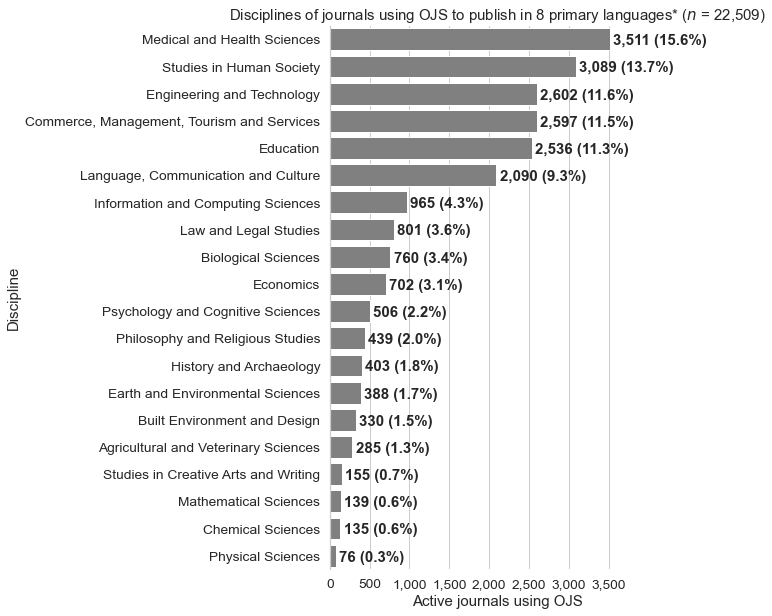

In [25]:
sns.set_theme(style="whitegrid", font_scale=1.25)

fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x="Count", y="Discipline", data=OJS,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 4200),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Disciplines of journals using OJS to publish in 8 primary languages* ($\it{n}$ = 22,509)')

matplotlib.pyplot.xticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500],
                         ['0', '500', '1,000', '1,500', '2,000', '2,500', '3,000',  '3,500'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.2
    percent = round(((p.get_width() / 22509) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 42, _y, value, ha='left', weight='bold')

plt.savefig('OJSdisciplines.png', bbox_inches='tight')

In [26]:
OJSpivot = OJS.pivot_table(columns='Discipline')

d = {'Division': ['Social Sciences', 'STEM', 'Humanities'],
     'Count': [OJSpivot[SOCSCI].values.sum(axis=1)[0],
               OJSpivot[STEM].values.sum(axis=1)[0],
               OJSpivot[HUM].values.sum(axis=1)[0]]}
d

{'Division': ['Social Sciences', 'STEM', 'Humanities'],
 'Count': [10231, 9191, 3087]}

#### B. Distribution of journals using OJS to publish in 7 primary languages*\n by their disciplinary coverage ($\it{n}$ = 22,491)<a id=div></a>

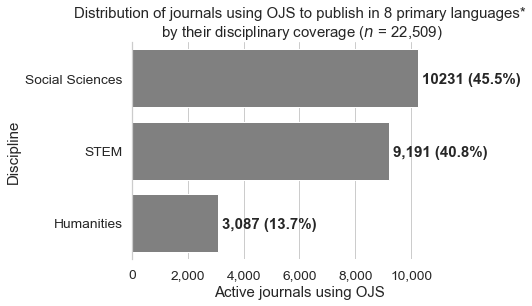

In [27]:
sns.set_theme(style="whitegrid", font_scale=1.25)

fig, ax = plt.subplots()

sns.barplot(x="Count", y="Division", data=d,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 12000),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in 8 primary languages*\n by their disciplinary coverage ($\it{n}$ = 22,509)')

matplotlib.pyplot.xticks([0, 2000, 4000, 6000, 8000, 10000],
                         ['0', '2,000', '4,000', '6,000', '8,000', '10,000'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 22509) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 150, _y, value, ha='left', weight='bold')

plt.savefig('OJSdivisions.png', bbox_inches='tight')

English:

In [ ]:
%%time 
EN = fosc(
    issn2payload=issn2payload_en, 
    model_id=model_id, 
    model=model)